<a href="https://colab.research.google.com/github/AhmedYounes94/ARBML/blob/master/AraBERTv2_ANERCorp_Undiacritic_CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We are using ANERCorp with Camel splits

The first part uses the Trainer API to quickly train the model


The second part defines a custom model and training loop which should be identical



**For AraBERTv1 and V2 you need to use the custom scripts** since the datasets library with the pyarrow backend dont support using farasapy

In [2]:
!pip install transformers
!pip install datasets
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!pip install pytorch-crf
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 1.9MB 16.3MB/s 
     |████████████████████████████████| 3.2MB 50.1MB/s 
     |████████████████████████████████| 890kB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=002270bc0fcd90432d253ac692958a72ca3cd79a50e465c289fd5ee50771464f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 18.6MB/s 
     |████████████████████████████████| 245kB 44.1MB/s 
     |████████████████████████████████| 112kB 41.7MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 112kB 17.8MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp37-none-any.whl size=113324 sha256=c5d1b6a12b122add073f41351077b910e1f1a

In [3]:
# !unzip "/content/drive/MyDrive/ANERcorp-CamelLabSplits.zip"

#Reading Data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
ANERCorp_path = '/content/drive/My Drive/data/'

excel_data = pd.read_excel(ANERCorp_path+'Final_ANERCorp.xlsx')
train, test = train_test_split(excel_data)
np.savetxt(ANERCorp_path+'Train.txt', train.values, fmt='%s' )
np.savetxt(ANERCorp_path+'Test.txt', test.values, fmt='%s' )

In [5]:
# !head -n100 ./ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line.split()[0]=='.':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [8]:
ANERCorp_path = '/content/drive/My Drive/data/'
# data_train = read_ANERcorp(ANERCorp_path+'diacritic_train.txt')
# data_test = read_ANERcorp(ANERCorp_path+'diacritic_test.txt')
data_train = read_ANERcorp(ANERCorp_path+'Train.txt')
data_test = read_ANERcorp(ANERCorp_path+'Test.txt')
data_all = read_ANERcorp(ANERCorp_path+'ANERCorp.txt')


In [9]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 28408, 'B-LOC': 1069, 'B-PERS': 854, 'I-PERS': 692, 'B-ORG': 453, 'I-ORG': 300, 'B-MISC': 252, 'I-LOC': 158, 'I-MISC': 124})
Counter({'O': 84939, 'B-LOC': 3200, 'B-PERS': 2586, 'I-PERS': 2010, 'B-ORG': 1461, 'I-ORG': 998, 'B-MISC': 818, 'I-LOC': 428, 'I-MISC': 344})


In [10]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['O', 'B-LOC', 'I-PERS', 'B-ORG', 'B-PERS', 'B-MISC', 'I-LOC', 'I-ORG', 'I-MISC']


Training Sentence Lengths: 


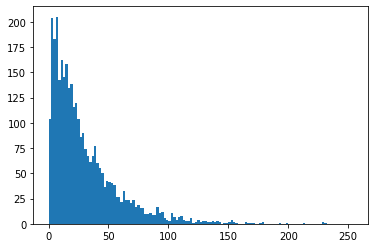

0
Testing Sentence Lengths: 


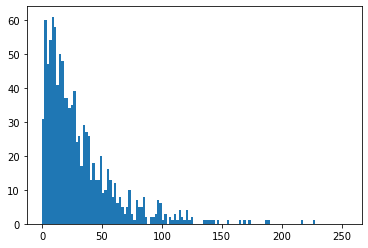

0


In [11]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

#NER with Trainer

In [12]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py

--2021-02-25 01:51:53--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19188 (19K) [text/plain]
Saving to: ‘run_ner.py’

run_ner.py          100%[===================>]  18.74K  --.-KB/s    in 0s      

2021-02-25 01:51:53 (137 MB/s) - ‘run_ner.py’ saved [19188/19188]



Converting data to huggingface supported format
1 json per line with "tokens" and "ner_tags" as keys

close to this for format https://github.com/huggingface/transformers/blob/master/tests/fixtures/tests_samples/conll/sample.json

In [13]:
import json

with open("train_data.json", "w") as outfile:
  for examples in data_train:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

with open("test_data.json", "w") as outfile:
  for examples in data_test:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

In [14]:
# !python run_ner.py \
#   --model_name_or_path aubmindlab/bert-large-arabertv02 \
#   --train_file train_data.json \
#   --validation_file test_data.json \
#   --output_dir ./test-ner \
#   --do_train \
#   --do_eval \
#   --per_device_train_batch_size 4 \
#   --gradient_accumulation_steps 8 \
#   --learning_rate 3e-5 \
#   --num_train_epochs 10 \
#   --warmup_steps 0 \
#   --evaluation_strategy epoch \
#   --save_steps 10000 \
#   --overwrite_output_dir \
#   --seed 42 \
#   --fp16 \

#NER with custom Model

##Model Files

In [15]:

from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess import ArabertPreprocessor, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [16]:
MAX_SEQ_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0
accumulation_steps = 1


#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv02'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)
arabert_prep = ArabertPreprocessor(BASE_MODEL_PATH.split("/")[-1])

In [17]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[0]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence[0]) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


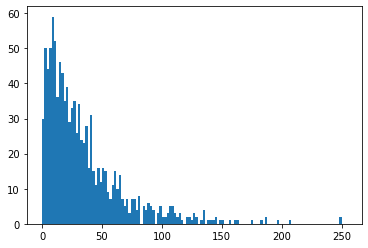

23


In [18]:
# check if the test_dataset is fully covered
tokenized_data = [TOKENIZER.tokenize(arabert_prep.preprocess(" ".join(sentence[0]))) for sentence in data_test]
plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
plt.show()
print(sum([len(x) > MAX_SEQ_LEN for x in tokenized_data]))

In [19]:
class NERDataset:
  def __init__(self, texts, tags, label_list, preprocessor):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = preprocessor    
    # self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    self.pad_token_label_id = 0


    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = TOKENIZER.tokenize(clean_word)

      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
      tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
      label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == MAX_SEQ_LEN
    assert len(attention_mask) == MAX_SEQ_LEN
    assert len(token_type_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }


In [20]:
import torch.nn.functional as F
from torchcrf import CRF
log_soft = F.log_softmax


In [21]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(self.bert.config.hidden_size, self.num_tag)
        self.crf = CRF(self.num_tag, batch_first=True)    

 
    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,output_hidden_states=True)
        bo_tag = self.bert_drop(output['last_hidden_state'])
        logits = self.out_tag(bo_tag)

        # loss_tag = loss_fn(logits, labels, attention_mask, self.num_tag)
        if labels is not None:
            attention_mask = attention_mask.type(torch.uint8)
            loss_tag = -self.crf(log_soft(logits, 2), labels, mask=attention_mask, reduction='mean')
        else:
            logits = self.crf.decode(emission, mask=attention_mask)

        return loss_tag, logits

In [22]:
inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions,label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [23]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for i, data in enumerate(tqdm(data_loader, total=len(data_loader))):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        loss.backward()
        final_loss += loss.item()
        if (i + 1 ) % accumulation_steps == 0:
          torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
          optimizer.step()
          scheduler.step()          
          optimizer.zero_grad()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      labels = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        logits = outputs[1]
        final_loss += loss.item()
        if logits is not None:        
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['labels'] is not None:
          labels = data['labels'] if labels is None else torch.cat((labels, data['labels']), dim=0)

      preds = preds.detach().cpu().numpy()
      labels = labels.cpu().numpy()     
    
    return compute_metrics(preds,labels), final_loss

In [24]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Thu Feb 25 01:52:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

##Training on all the training data


In [25]:
# fold_best_f1 = 0
# best_fold = None
# for fold_num , (train, test) in enumerate(kf.split(data_all)):
#   print("Starting Fold Num: ", fold_num)
#   train_dataset = NERDataset(
#     texts= [x[0] for x in [data_all[x] for x in train]],
#     tags = [x[1] for x in [data_all[x] for x in train]],
#     label_list = label_list,
#     preprocessor=arabert_prep)

#   train_dataloader = torch.utils.data.DataLoader(
#       dataset=train_dataset,
#       batch_size=TRAIN_BATCH_SIZE,
#       num_workers=2
#   )

#   test_dataset = NERDataset(
#       texts= [x[0] for x in [ data_all[x] for x in test]],
#       tags = [x[1] for x in [ data_all[x] for x in test]],
#       label_list = label_list,
#       preprocessor=arabert_prep)

#   test_dataloader = torch.utils.data.DataLoader(
#       dataset=test_dataset,
#       batch_size=VALID_BATCH_SIZE,
#       num_workers=1
#   )
#   num_tag = len(label_list)
#   model = NERModel(num_tag=num_tag)
#   model.to(device)
#   print('MODEL LOADED!')

#   param_optimizer = list(model.named_parameters())
#   no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#   optimizer_parameters = [
#       {
#           "params": [
#               p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
#           ],
#           "weight_decay": 0.01,
#       },
#       {
#           "params": [
#               p for n, p in param_optimizer if any(nd in n for nd in no_decay)
#           ],
#           "weight_decay": 0.0,
#       },
#   ]

#   num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
#   print('Number of training steps: ', num_train_steps)
#   optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
#   scheduler = get_linear_schedule_with_warmup(
#       optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
#   )

#   for epoch in range(EPOCHS):
#       train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
#       eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
#       print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
#       print(eval_metrics)
train_dataset = NERDataset(
    texts= [x[0] for x in data_train],
    tags = [x[1] for x in data_train],
    label_list = label_list,
    preprocessor=arabert_prep)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=2
)

test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    preprocessor=arabert_prep)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [26]:
EPOCHS = 15

In [27]:
num_tag = len(label_list)
model = NERModel(num_tag=num_tag)
model.to(device)
print('MODEL LOADED!')

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
print('Number of training steps: ', num_train_steps)
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
)

for epoch in range(EPOCHS):
    train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
    eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
    print(eval_metrics)


MODEL LOADED!
Number of training steps:  3072


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

         LOC     0.8402    0.8064    0.8229      1193
        MISC     0.7377    0.2459    0.3689       366
         ORG     0.6168    0.4599    0.5269       735
        PERS     0.8158    0.8066    0.8112      1494

   micro avg     0.7883    0.6851    0.7331      3788
   macro avg     0.7526    0.5797    0.6325      3788
weighted avg     0.7773    0.6851    0.7170      3788

Train Loss = 17.458724267308305 Valid Loss = 845.3339730501175
{'accuracy_score': 0.9860591761633428, 'precision': 0.7882746051032807, 'recall': 0.6850580781414994, 'f1': 0.7330508474576272}



              precision    recall  f1-score   support

         LOC     0.8573    0.8458    0.8515      1193
        MISC     0.6347    0.3798    0.4752       366
         ORG     0.6576    0.5592    0.6044       735
        PERS     0.8414    0.8240    0.8326      1494

   micro avg     0.8008    0.7365    0.7673      3788
   macro avg     0.7477    0.6522    0.6909      3788
weighted avg     0.7908    0.7365    0.7597      3788

Train Loss = 5.820223987393263 Valid Loss = 730.5339312553406
{'accuracy_score': 0.9874910968660968, 'precision': 0.8008036739380023, 'recall': 0.7365364308342133, 'f1': 0.7673267326732672}



              precision    recall  f1-score   support

         LOC     0.8450    0.8500    0.8475      1193
        MISC     0.6429    0.4426    0.5243       366
         ORG     0.6806    0.5741    0.6229       735
        PERS     0.8374    0.8133    0.8251      1494

   micro avg     0.7985    0.7426    0.7695      3788
   macro avg     0.7515    0.6700    0.7049      3788
weighted avg     0.7906    0.7426    0.7639      3788

Train Loss = 4.326854573226557 Valid Loss = 780.495433807373
{'accuracy_score': 0.9874985161443495, 'precision': 0.7984672154413852, 'recall': 0.7426082365364308, 'f1': 0.7695253727260293}



              precision    recall  f1-score   support

         LOC     0.8333    0.8843    0.8581      1193
        MISC     0.5382    0.4809    0.5079       366
         ORG     0.6683    0.5701    0.6153       735
        PERS     0.8772    0.7744    0.8226      1494

   micro avg     0.7932    0.7410    0.7662      3788
   macro avg     0.7293    0.6774    0.7010      3788
weighted avg     0.7901    0.7410    0.7631      3788

Train Loss = 3.3362932039470206 Valid Loss = 882.9958302974701
{'accuracy_score': 0.9874688390313391, 'precision': 0.7931619101441085, 'recall': 0.7410242872228089, 'f1': 0.7662071789272553}



              precision    recall  f1-score   support

         LOC     0.8706    0.8458    0.8580      1193
        MISC     0.5443    0.4863    0.5137       366
         ORG     0.6853    0.5510    0.6109       735
        PERS     0.8476    0.8039    0.8251      1494

   micro avg     0.7994    0.7373    0.7671      3788
   macro avg     0.7369    0.6718    0.7019      3788
weighted avg     0.7940    0.7373    0.7638      3788

Train Loss = 2.4718332212145735 Valid Loss = 975.8885651826859
{'accuracy_score': 0.9872462606837606, 'precision': 0.7993703491700057, 'recall': 0.7373284054910243, 'f1': 0.7670969513869816}



              precision    recall  f1-score   support

         LOC     0.8659    0.8282    0.8466      1193
        MISC     0.5525    0.4891    0.5188       366
         ORG     0.6159    0.6000    0.6079       735
        PERS     0.8112    0.8400    0.8254      1494

   micro avg     0.7680    0.7558    0.7618      3788
   macro avg     0.7114    0.6893    0.6997      3788
weighted avg     0.7656    0.7558    0.7602      3788

Train Loss = 1.835365853222405 Valid Loss = 1028.173308134079
{'accuracy_score': 0.9865933641975309, 'precision': 0.7679721030042919, 'recall': 0.7558078141499472, 'f1': 0.7618414050026611}



              precision    recall  f1-score   support

         LOC     0.8538    0.8374    0.8455      1193
        MISC     0.6000    0.5082    0.5503       366
         ORG     0.6131    0.6122    0.6127       735
        PERS     0.8468    0.7992    0.8223      1494

   micro avg     0.7806    0.7468    0.7634      3788
   macro avg     0.7284    0.6893    0.7077      3788
weighted avg     0.7798    0.7468    0.7627      3788

Train Loss = 1.3665253285227752 Valid Loss = 1140.1749775409698
{'accuracy_score': 0.9869494895536562, 'precision': 0.7806291390728477, 'recall': 0.746832101372756, 'f1': 0.7633567188343229}



              precision    recall  f1-score   support

         LOC     0.8600    0.8391    0.8494      1193
        MISC     0.5633    0.4617    0.5075       366
         ORG     0.6403    0.5619    0.5986       735
        PERS     0.8444    0.7918    0.8173      1494

   micro avg     0.7880    0.7302    0.7580      3788
   macro avg     0.7270    0.6636    0.6932      3788
weighted avg     0.7825    0.7302    0.7550      3788

Train Loss = 0.9932554241269826 Valid Loss = 1294.67489695549
{'accuracy_score': 0.986838200379867, 'precision': 0.788034188034188, 'recall': 0.7302006335797254, 'f1': 0.7580158947656892}



              precision    recall  f1-score   support

         LOC     0.8161    0.8743    0.8442      1193
        MISC     0.5153    0.5055    0.5103       366
         ORG     0.6646    0.5823    0.6207       735
        PERS     0.8286    0.8059    0.8171      1494

   micro avg     0.7659    0.7550    0.7604      3788
   macro avg     0.7062    0.6920    0.6981      3788
weighted avg     0.7626    0.7550    0.7579      3788

Train Loss = 0.716602261605241 Valid Loss = 1339.769257068634
{'accuracy_score': 0.9865414292497626, 'precision': 0.7659346545259775, 'recall': 0.7550158394931362, 'f1': 0.7604360542408936}



              precision    recall  f1-score   support

         LOC     0.8517    0.8567    0.8542      1193
        MISC     0.4973    0.4973    0.4973       366
         ORG     0.6041    0.6000    0.6020       735
        PERS     0.8288    0.8133    0.8209      1494

   micro avg     0.7602    0.7550    0.7576      3788
   macro avg     0.6955    0.6918    0.6936      3788
weighted avg     0.7604    0.7550    0.7577      3788

Train Loss = 0.5171924619890023 Valid Loss = 1491.6917972564697
{'accuracy_score': 0.9865636870845205, 'precision': 0.7602339181286549, 'recall': 0.7550158394931362, 'f1': 0.7576158940397351}



              precision    recall  f1-score   support

         LOC     0.8401    0.8541    0.8470      1193
        MISC     0.5169    0.5027    0.5097       366
         ORG     0.6107    0.6190    0.6149       735
        PERS     0.8192    0.8005    0.8097      1494

   micro avg     0.7562    0.7534    0.7548      3788
   macro avg     0.6967    0.6941    0.6953      3788
weighted avg     0.7561    0.7534    0.7547      3788

Train Loss = 0.4110382372888214 Valid Loss = 1518.9724009037018
{'accuracy_score': 0.9864746557454891, 'precision': 0.7562268150503445, 'recall': 0.7534318901795143, 'f1': 0.7548267654059773}



              precision    recall  f1-score   support

         LOC     0.8523    0.8466    0.8495      1193
        MISC     0.5705    0.4754    0.5186       366
         ORG     0.6353    0.6068    0.6207       735
        PERS     0.8203    0.8126    0.8164      1494

   micro avg     0.7745    0.7508    0.7625      3788
   macro avg     0.7196    0.6854    0.7013      3788
weighted avg     0.7703    0.7508    0.7601      3788

Train Loss = 0.2801145016726833 Valid Loss = 1636.7715256214142
{'accuracy_score': 0.9868085232668566, 'precision': 0.7745098039215687, 'recall': 0.750791974656811, 'f1': 0.7624664879356569}



              precision    recall  f1-score   support

         LOC     0.8605    0.8483    0.8544      1193
        MISC     0.5884    0.4727    0.5242       366
         ORG     0.6178    0.6245    0.6211       735
        PERS     0.8528    0.7952    0.8230      1494

   micro avg     0.7854    0.7476    0.7660      3788
   macro avg     0.7299    0.6852    0.7057      3788
weighted avg     0.7841    0.7476    0.7648      3788

Train Loss = 0.2368532480308559 Valid Loss = 1741.4562768936157
{'accuracy_score': 0.9871572293447294, 'precision': 0.7853577371048253, 'recall': 0.747624076029567, 'f1': 0.7660265079794427}



              precision    recall  f1-score   support

         LOC     0.8570    0.8391    0.8479      1193
        MISC     0.5141    0.4973    0.5056       366
         ORG     0.6450    0.5810    0.6113       735
        PERS     0.8260    0.8166    0.8213      1494

   micro avg     0.7730    0.7471    0.7598      3788
   macro avg     0.7105    0.6835    0.6965      3788
weighted avg     0.7705    0.7471    0.7584      3788

Train Loss = 0.2040877251476958 Valid Loss = 1745.9525886774063
{'accuracy_score': 0.986801103988604, 'precision': 0.7730128380223983, 'recall': 0.7470960929250264, 'f1': 0.7598335347026447}



              precision    recall  f1-score   support

         LOC     0.8573    0.8458    0.8515      1193
        MISC     0.5559    0.4754    0.5125       366
         ORG     0.6211    0.6245    0.6228       735
        PERS     0.8320    0.8086    0.8201      1494

   micro avg     0.7742    0.7524    0.7632      3788
   macro avg     0.7166    0.6886    0.7017      3788
weighted avg     0.7723    0.7524    0.7620      3788

Train Loss = 0.16019690959464486 Valid Loss = 1758.982456088066
{'accuracy_score': 0.9868752967711301, 'precision': 0.7742461287693562, 'recall': 0.752375923970433, 'f1': 0.7631543714017941}


#Results and hyper parameters

AraBERTv1

                  precision    recall  f1-score   support

             LOC     0.8919    0.9275    0.9094       676
            MISC     0.7389    0.6173    0.6726       243
             ORG     0.7748    0.6972    0.7339       459
            PERS     0.8499    0.8320    0.8409       905

       micro avg     0.8390    0.8103    0.8244      2283
       macro avg     0.8139    0.7685    0.7892      2283
    weighted avg     0.8354    0.8103    0.8217      2283

    Train Loss = 0.02561288744304329
    Valid Loss = 18.984092206461355
    'accuracy_score': 0.9703493257572726
    'precision': 0.8390022675736961
    'recall': 0.8103372755146737
    'f1': 0.8244206773618539

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 7e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0

AraBERTv0.2

                precision    recall  f1-score   support

           LOC     0.8886    0.9320    0.9097       676
          MISC     0.7590    0.6091    0.6758       243
           ORG     0.7935    0.7451    0.7685       459
          PERS     0.8832    0.8442    0.8633       905

      micro avg     0.8564    0.8252    0.8405      2283
      macro avg     0.8311    0.7826    0.8043      2283
      weighted avg     0.8536    0.8252    0.8380      2283

      Train Loss = 0.018847705767024308
      Valid Loss = 18.27915945305722
      'accuracy_score': 0.9722211071414235
      'precision': 0.8563636363636363
      'recall': 0.8252299605781866
      'f1': 0.8405085879991078

      MAX_SEQ_LEN = 256
      TRAIN_BATCH_SIZE = 32
      VALID_BATCH_SIZE = 8
      EPOCHS = 6
      LEARNING_RATE = 5e-5
      WARMUP_RATIO = 0.1
      MAX_GRAD_NORM = 1.0

AraELECTRA

                  precision    recall  f1-score   support

             LOC     0.8914    0.9349    0.9126       676
            MISC     0.7241    0.6049    0.6592       243
             ORG     0.8292    0.7298    0.7764       459
            PERS     0.8908    0.8475    0.8686       905

        micro avg     0.8640    0.8239    0.8435      2283
        macro avg     0.8339    0.7793    0.8042      2283
     weighted avg     0.8609    0.8239    0.8408      2283

    Train Loss = 0.012127994215115906
    Valid Loss = 20.18689019192243
    'accuracy_score': 0.9724218216851993
    'precision': 0.8640330730362885
    'recall': 0.823915900131406
    'f1': 0.8434977578475337}

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 10 # only 9 needed
    LEARNING_RATE = 5e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0